Author: Prabin

# Part 2

# JPEG Overview:

  1. Convert RGB to YCbCr: Separate luminance (Y) from chrominance (Cb, Cr) since human vision is more sensitive to brightness.

  2. Chroma Subsampling (4:2:0): Reduce chrominance resolution by averaging blocks of pixels.

  3. Divide into 8x8 Blocks: Process the image in small blocks for DCT computation.

  4. Apply Discrete Cosine Transform (DCT): Convert spatial data into frequency components.

  5. Quantization: Reduce high-frequency components (lossy step) using a quantization matrix.

  6. Zigzag Scanning: Reorder coefficients for efficient entropy encoding.

  7. Run-Length & Huffman Encoding: Compress data further (not always visualized).

## Step 1: Import libraries

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io
from scipy.fftpack import dct, idct

## Step 2: Image preparation:

- Lena test image is standard test image

In [ ]:
img_url = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'
img = io.imread(img_url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Fix color channels


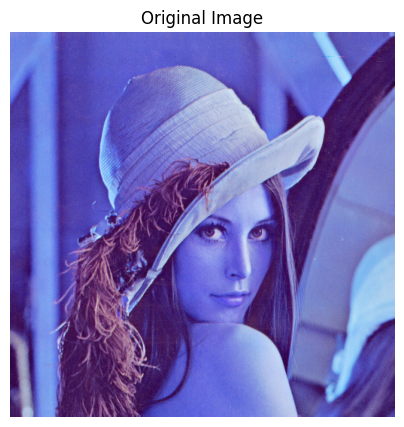

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()


## Step 3: RGB to YCbCr Conversion:

Why:

  - Human eyes are more sensitive to brightness (Y) than color (Cb/Cr).

  - Separating luminance allows aggressive compression of chrominance.


Luminance and Grayscale are similar, not the same:
1. Grayscale is used for visual representation, Luminance for compression and processing. Luminance has less color info because color info is separated from it in chroma channels.
2. Grayscale is single channel image, Luminance is a part of multi-channel (Y,Cb,Cr)

In [ ]:
# ## **Step 3: Convert RGB to YCbCr (Luminance & Chrominance)**
img_ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
Y, Cb, Cr = cv2.split(img_ycbcr)

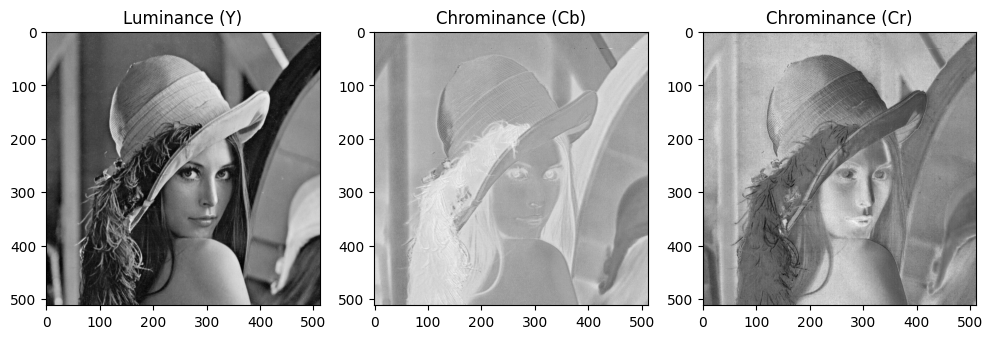

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131), plt.imshow(Y, cmap='gray'), plt.title("Luminance (Y)")
plt.subplot(132), plt.imshow(Cb, cmap='gray'), plt.title("Chrominance (Cb)")
plt.subplot(133), plt.imshow(Cr, cmap='gray'), plt.title("Chrominance (Cr)")
plt.show()

## Step 4: Chroma Subsampling:

What we do:

- Downsample Cb and Cr to half resolution (e.g., 256×256 → 128×128).

Why:

  - Because color info isn't needed at full resolution. This saves 50% of chroma data

  - "4:2:0" Notation means for every 2x2 block of Y, there's 1 Cb and 1 Cr sample.
  
  Elaboration:
    - Imagine 2x2 grid of pixels
    - Notation means shothand notation to describe how chroma samples (Cb and Cr) are stored relative to luminance (Y)
    - 4 means 4 Y pixels (full resolution)
    - 2 means Cb and Cr are sampled once per 2 pixels horizontally
    - 0 means Cb and Cr are sampled once every 2 rows (none vertically per row)

In [ ]:
# ## **Step 4: Chroma Subsampling (4:2:0)**
def subsample(channel):
    return cv2.resize(channel, (channel.shape[1]//2, channel.shape[0]//2), interpolation=cv2.INTER_LINEAR)

array([[114, 118, 113, ..., 113, 108, 113],
       [114, 118, 113, ..., 113, 108, 113],
       [113, 115, 113, ..., 114, 112, 122],
       ...,
       [140, 139, 139, ..., 130, 126, 128],
       [143, 140, 141, ..., 130, 126, 126],
       [141, 139, 140, ..., 127, 124, 123]], dtype=uint8)
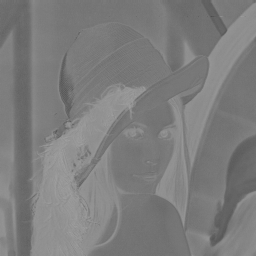

In [ ]:
Cb_subsampled = subsample(Cb)
Cb_subsampled


array([[174, 172, 177, ..., 174, 174, 179],
       [174, 172, 177, ..., 174, 174, 179],
       [174, 175, 177, ..., 175, 177, 175],
       ...,
       [154, 154, 156, ..., 168, 174, 177],
       [154, 156, 156, ..., 170, 178, 179],
       [152, 155, 157, ..., 174, 182, 182]], dtype=uint8)
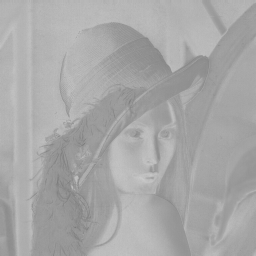

In [ ]:
Cr_subsampled = subsample(Cr)
Cr_subsampled

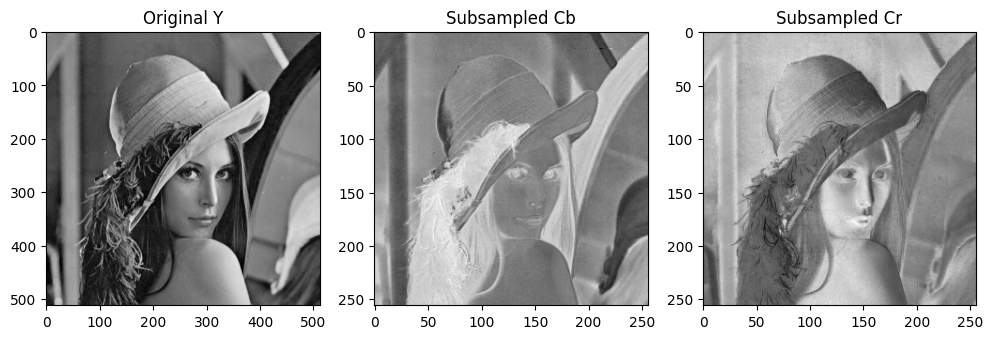

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131), plt.imshow(Y, cmap='gray'), plt.title("Original Y")
plt.subplot(132), plt.imshow(Cb_subsampled, cmap='gray'), plt.title("Subsampled Cb")
plt.subplot(133), plt.imshow(Cr_subsampled, cmap='gray'), plt.title("Subsampled Cr")
plt.show()

## Step 5: Divide into 8x8 blocks:

What we do:
- Split the Y channel into 8×8 blocks (e.g., 512×512 image→ 64×64 = 4096 blocks).
  - Because 1 block = 8x8 pixels = 64 pixels

Why:

  - DCT operates on small blocks to localize frequency analysis.

  - Smaller blocks = better compression of localized features.


We apply DCT block by block, Applying 2D DCT gives us frequency coefficients for a particular block.

In [ ]:
# ## **Step 5: Divide into 8x8 Blocks (Example on Y Channel)**
def split_blocks(channel, block_size=8):
    h, w = channel.shape
    blocks = []
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            blocks.append(channel[i:i+block_size, j:j+block_size])
    return blocks

In [ ]:
Y_blocks = split_blocks(Y)
print(f"Total {len(Y_blocks)} blocks of size 8x8")

Total 4096 blocks of size 8x8


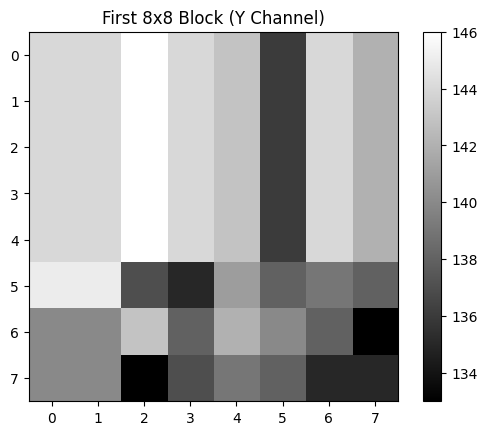

In [ ]:
# Visualize first block
plt.imshow(Y_blocks[0], cmap='gray')
plt.title("First 8x8 Block (Y Channel)")
plt.colorbar()
plt.show()

## Step 6: DCT:

What we do:
- Subtracting 128 centers pixels around 0 (JPEG convention, you can try with different numbers)
- Apply DCT to each 8×8 block:

Why:

  - Converts spatial pixel data into frequency components.
    - Concentrates visual information into a small number of coefficients

  - Low-frequency (top-left) → High-frequency (bottom-right).

  - Human vision prioritizes low frequencies, so high frequencies can be discarded.


What DCT Output Represents:

- Each coefficient in DCT tells us how much of a particular **cosine wave pattern** is present in that block.
- DCT breaks the image into weighted sums of wave patterns
- Top-left corner: Low frequency(slow changes. e.g. average brightness)
- Bottom-right: High frequency (rapid changes. e.g. noises, edges)
- Most energy is concentrated in the top-left block, that's what JPEG exploits


What is Frequency in images?
- Freqency: How fast pixel change across space
- High frequencies are textures, noise, small details. JPEG compresses better if we ignore these, humans barely notice these

Why is DC = Average Brightness?
- The (0,0) DCT coefficient is DC component (has zero frequency)
- Mathematically, its proportional to the mean of the pixel block
- Because cosine of zero = 1. DCT at (0,0) adds up all pixels evenly


Why log scale?
- DC might be 800, high frequency might be 1, -2, etc.. To see them all clearly, we compress the dynamic range, so applying log will make small values visible and larger values manageable in the plot


In [ ]:
# ## **Step 6: Apply DCT (Discrete Cosine Transform)**
block = Y_blocks[0].astype(float) - 128  # Center around 0
block_dct = dct(dct(block.T, norm='ortho').T, norm='ortho')

In [ ]:
# # ## **Step 6: Apply DCT (Discrete Cosine Transform)**
# block = Y_blocks[0].astype(float)
# block_dct = dct(dct(block.T, norm='ortho').T, norm='ortho')

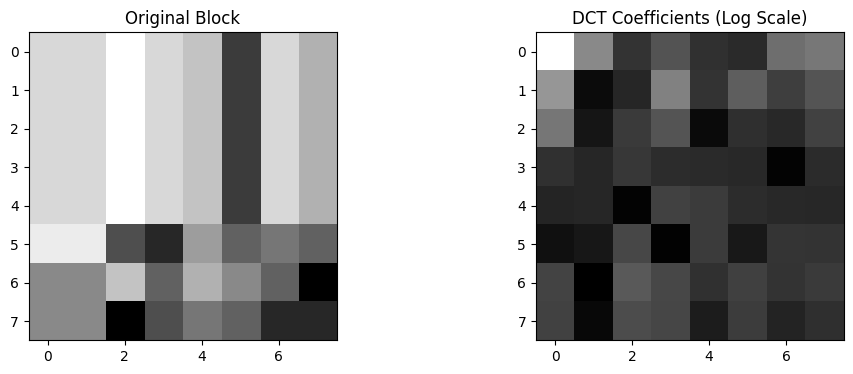

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.imshow(block, cmap='gray'), plt.title("Original Block")
plt.subplot(122), plt.imshow(np.log(abs(block_dct)+1), cmap='gray'), plt.title("DCT Coefficients (Log Scale)")
plt.show()

## Step 7: Quantization:

What we do:
- Divide DCT coefficients by a quantization matrix (Q) and round

Why:

  - Q matrix defines compression strength:

      - Larger values → More aggressive quantization → Smaller file size.
      - Each number in Q matrix tells us how much precision to keep for that frequency position
        - Small Q (e.g. 16) : Preserve value more accurately
        - Large Q (e.g. 99): Aggressively round, might go to 0

  - High-frequency coefficients (bottom-right of Q) are divided by larger numbers → Many become 0 (lossy step).

In [ ]:
# ## **Step 7: Quantization (Lossy Step)**
# Standard JPEG quantization matrix for Luminance
Q = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

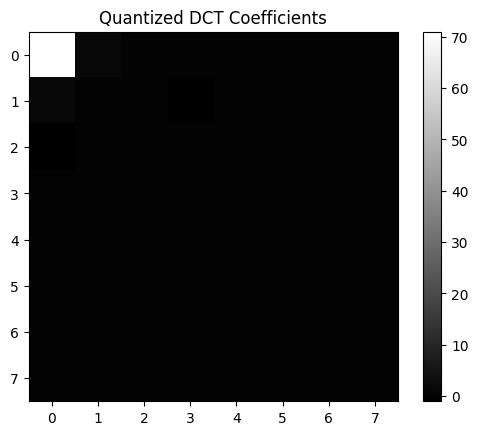

In [ ]:
quantized = np.round(block_dct / Q)
plt.imshow(quantized, cmap='gray')
plt.title("Quantized DCT Coefficients")
plt.colorbar()
plt.show()

## Step 8: Dequantization and Reconstruction:

Why:

  - Reconstructs the image block from quantized frequencies.

  - Loss occurs here: High-frequency data lost during quantization cannot be fully recovered.


In [ ]:
# ## **Step 8: Dequantization & Inverse DCT (Reconstruction)**
dequantized = quantized * Q
reconstructed = idct(idct(dequantized.T, norm='ortho').T, norm='ortho') + 128

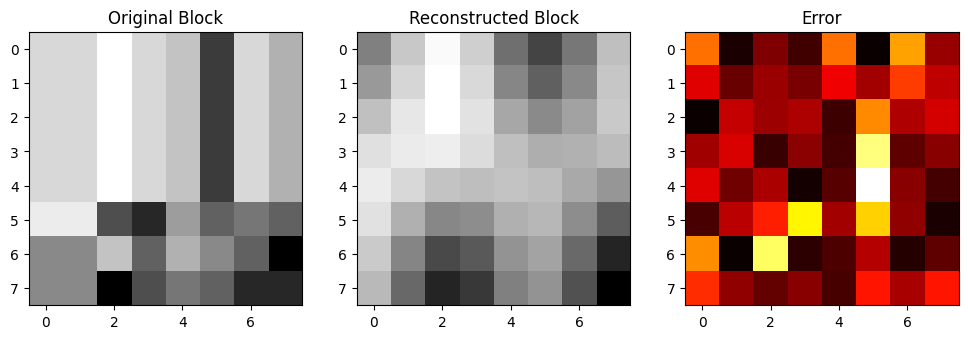

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131), plt.imshow(block + 128, cmap='gray'), plt.title("Original Block")
plt.subplot(132), plt.imshow(reconstructed, cmap='gray'), plt.title("Reconstructed Block")
plt.subplot(133), plt.imshow(abs(block + 128 - reconstructed), cmap='hot'), plt.title("Error")
plt.show()


## Step 9: Full Image Compression:

What we do:
- Implement jpeg_compress() to:

  1. Process all 8×8 blocks of Y.

  2. Upsample Cb/Cr to original size (if subsampled).

  3. Merge channels and convert back to RGB.

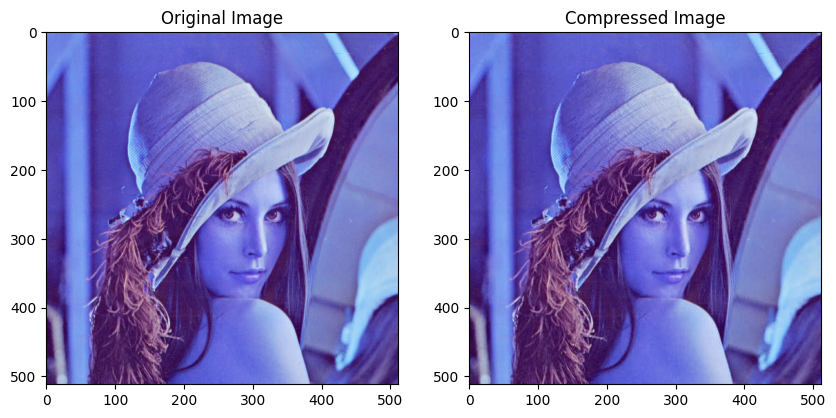

In [ ]:
def jpeg_compress(img, Q, subsample=True):
    # RGB to YCbCr
    img_ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    Y, Cb, Cr = cv2.split(img_ycbcr)

    # Chroma subsampling
    if subsample:
        Cb_subsampled = cv2.resize(Cb, (Cb.shape[1]//2, Cb.shape[0]//2), interpolation=cv2.INTER_LINEAR)
        Cr_subsampled = cv2.resize(Cr, (Cr.shape[1]//2, Cr.shape[0]//2), interpolation=cv2.INTER_LINEAR)
    else:
        Cb_subsampled = Cb.copy()
        Cr_subsampled = Cr.copy()

    # Process Y channel
    Y_reconstructed = np.zeros_like(Y, dtype=float)
    for i in range(0, Y.shape[0], 8):
        for j in range(0, Y.shape[1], 8):
            block = Y[i:i+8, j:j+8].astype(float) - 128
            block_dct = dct(dct(block.T, norm='ortho').T, norm='ortho')
            quantized = np.round(block_dct / Q)
            dequantized = quantized * Q
            reconstructed = idct(idct(dequantized.T, norm='ortho').T, norm='ortho') + 128
            Y_reconstructed[i:i+8, j:j+8] = reconstructed

    # Upsample Cb and Cr to original dimensions before merging
    if subsample:
        Cb_upsampled = cv2.resize(Cb_subsampled, (Y.shape[1], Y.shape[0]), interpolation=cv2.INTER_LINEAR)
        Cr_upsampled = cv2.resize(Cr_subsampled, (Y.shape[1], Y.shape[0]), interpolation=cv2.INTER_LINEAR)
    else:
        Cb_upsampled = Cb_subsampled
        Cr_upsampled = Cr_subsampled

    # Merge channels and convert back to RGB
    img_reconstructed = cv2.merge((
        Y_reconstructed.astype(np.uint8),
        Cb_upsampled.astype(np.uint8),
        Cr_upsampled.astype(np.uint8)
    ))
    img_reconstructed = cv2.cvtColor(img_reconstructed, cv2.COLOR_YCrCb2RGB)

    return img_reconstructed

compressed_img = jpeg_compress(img, Q)

plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(img), plt.title("Original Image")
plt.subplot(122), plt.imshow(compressed_img), plt.title("Compressed Image")
plt.show()

## Step 10: PSNR:

- Higher PSNR → Better quality (less distortion).

- Typical values:
  - 30 dB = Good.
  - 20-30 = Noticeable artifacts.

In [ ]:
# ## **Step 10: Calculate PSNR (Quality Metric)**
def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    return 10 * np.log10(255**2 / mse)

psnr_value = psnr(img, compressed_img)
print(f"PSNR: {psnr_value:.2f} dB")

PSNR: 34.55 dB
